In [1]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [2]:
!unzip "/content/drive/MyDrive/TrashBox_train_set.zip"

Streaming output truncated to the last 5000 lines.
  inflating: TrashBox_train_set/medical/medical 1322.jpg  
  inflating: __MACOSX/TrashBox_train_set/medical/._medical 1322.jpg  
  inflating: TrashBox_train_set/medical/medical 1444.jpg  
  inflating: __MACOSX/TrashBox_train_set/medical/._medical 1444.jpg  
  inflating: TrashBox_train_set/medical/medical 746.jpg  
  inflating: __MACOSX/TrashBox_train_set/medical/._medical 746.jpg  
  inflating: TrashBox_train_set/medical/medical 1875.jpg  
  inflating: __MACOSX/TrashBox_train_set/medical/._medical 1875.jpg  
  inflating: TrashBox_train_set/medical/medical 1861.jpg  
  inflating: __MACOSX/TrashBox_train_set/medical/._medical 1861.jpg  
  inflating: TrashBox_train_set/medical/medical 593.jpg  
  inflating: __MACOSX/TrashBox_train_set/medical/._medical 593.jpg  
  inflating: TrashBox_train_set/medical/medical 1691.jpg  
  inflating: __MACOSX/TrashBox_train_set/medical/._medical 1691.jpg  
  inflating: TrashBox_train_set/medical/medical 58

In [3]:
data_dir = "TrashBox_train_set"

In [14]:
transform = transforms.Compose([
      transforms.Resize((227,227)),
      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
      transforms.RandomHorizontalFlip(0.3),
      transforms.RandomVerticalFlip(0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      ])

In [15]:
dataset = ImageFolder(data_dir, transform = transform)

Label: cardboard (Class No: 0)


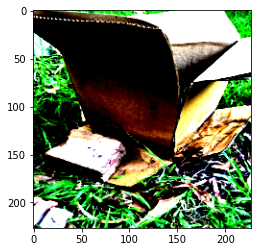

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[12]
show_sample(img, label)

In [17]:
random_seed = 42
torch.manual_seed(random_seed)

In [18]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(9997, 2142, 2143)

In [19]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

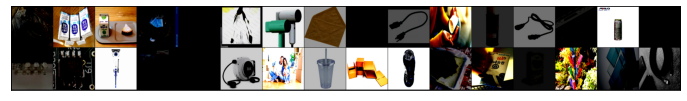

In [22]:
show_batch(train_dl)

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
from torch.nn.modules import loss
from torch.optim.adam import Adam
num_epochs = 20
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss();

In [29]:
from torch.autograd import Variable
#Model Training and saving best Model
best_accuracy = 0.0
train_acc_list = []
test_acc_list = []
val_acc_list = []
train_loss_list = []
test_loss_list = []
val_loss_list = []
epo = []
for epoch in range(num_epochs):
  #evaluation and training on training dataset
  model.train()
  train_acc = 0.0
  train_loss = 0.0

  for i, (images, labels) in enumerate(train_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)

    train_acc += int(torch.sum(prediction==labels.data))

  train_acc = train_acc / train_size
  train_loss = train_loss / train_size
      
  #Evaluation on testing dataset
  model.eval()

  test_acc = 0.0
  correct1 = 0
  total1 = 0
  test_loss = 0.0

  for i, (images, labels) in enumerate(test_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    test_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    test_acc += int(torch.sum(prediction==labels.data))
    total1 += labels.size(0)
    correct1 += (prediction == labels).sum().item()
  
  test_acc = test_acc / test_size
  test_loss = test_loss / test_size

  val_acc = 0.0
  correct2 = 0
  total2 = 0
  val_loss = 0.0

  for i, (images, labels) in enumerate(val_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    val_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    val_acc += int(torch.sum(prediction==labels.data))
    total2 += labels.size(0)
    correct2 += (prediction == labels).sum().item()

  val_loss = val_loss / val_size
  val_acc = val_acc / val_size
  print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss)+ ' Train Accuracy: '+str(train_acc) + 
                              ' Test Accuracy: '+str(test_acc) + 
                               ' Validation Loss: '+str(val_loss)+ ' Validation Accuracy: '+str(val_acc))
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  val_acc_list.append(val_acc)
  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  val_loss_list.append(val_loss)
  epo.append(epoch+1)

  if(test_acc>best_accuracy):
    torch.save(model.state_dict(), 'best_checkpoint.model')
    best_accuracy = test_acc
print('Test Accuracy of the model on the {} test images: {} %'.format(total1, (correct1 / total1) * 100))
print('Test Accuracy of the model on the {} validation images: {} %'.format(total2, (correct2 / total2) * 100))

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 1 Train Loss: tensor(1.4382) Train Accuracy: 0.5229568870661199 Test Accuracy: 0.6864209052729818 Validation Loss: tensor(1.1930) Validation Accuracy: 0.6774042950513539


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 2 Train Loss: tensor(0.8689) Train Accuracy: 0.6986095828748624 Test Accuracy: 0.7181521231917872 Validation Loss: tensor(0.4694) Validation Accuracy: 0.7254901960784313


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 3 Train Loss: tensor(0.6956) Train Accuracy: 0.75962788836651 Test Accuracy: 0.730284647690154 Validation Loss: tensor(0.9626) Validation Accuracy: 0.7217553688141923


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 4 Train Loss: tensor(0.5763) Train Accuracy: 0.7995398619585876 Test Accuracy: 0.7517498833411106 Validation Loss: tensor(0.3124) Validation Accuracy: 0.7315592903828197


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 5 Train Loss: tensor(0.5020) Train Accuracy: 0.8252475742722817 Test Accuracy: 0.7615492300513299 Validation Loss: tensor(0.4530) Validation Accuracy: 0.738562091503268


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 6 Train Loss: tensor(0.4348) Train Accuracy: 0.8493548064419326 Test Accuracy: 0.7704153056462902 Validation Loss: tensor(0.1788) Validation Accuracy: 0.7600373482726424


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 7 Train Loss: tensor(0.3812) Train Accuracy: 0.8684605381614484 Test Accuracy: 0.7615492300513299 Validation Loss: tensor(0.4522) Validation Accuracy: 0.7455648926237162


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 8 Train Loss: tensor(0.3438) Train Accuracy: 0.8801640492147644 Test Accuracy: 0.7769482034531031 Validation Loss: tensor(0.3075) Validation Accuracy: 0.7721755368814193


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 9 Train Loss: tensor(0.3240) Train Accuracy: 0.8899669900970291 Test Accuracy: 0.7797480167988801 Validation Loss: tensor(0.0649) Validation Accuracy: 0.7721755368814193


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 10 Train Loss: tensor(0.2907) Train Accuracy: 0.9031709512853856 Test Accuracy: 0.7811479234717685 Validation Loss: tensor(0.1347) Validation Accuracy: 0.7609710550887021


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 11 Train Loss: tensor(0.2625) Train Accuracy: 0.9137741322396719 Test Accuracy: 0.7769482034531031 Validation Loss: tensor(0.2000) Validation Accuracy: 0.7647058823529411


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 12 Train Loss: tensor(0.2363) Train Accuracy: 0.9205761728518556 Test Accuracy: 0.7839477368175455 Validation Loss: tensor(0.1655) Validation Accuracy: 0.7717086834733894


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 13 Train Loss: tensor(0.2314) Train Accuracy: 0.9206762028608583 Test Accuracy: 0.8002799813345777 Validation Loss: tensor(0.0320) Validation Accuracy: 0.7726423902894491


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 14 Train Loss: tensor(0.2092) Train Accuracy: 0.929478843653096 Test Accuracy: 0.781614559029398 Validation Loss: tensor(0.1834) Validation Accuracy: 0.7745098039215687


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 15 Train Loss: tensor(0.1990) Train Accuracy: 0.9340802240672201 Test Accuracy: 0.7984134391040597 Validation Loss: tensor(0.2128) Validation Accuracy: 0.7749766573295985


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 16 Train Loss: tensor(0.2073) Train Accuracy: 0.9308792637791338 Test Accuracy: 0.7909472701819878 Validation Loss: tensor(0.1929) Validation Accuracy: 0.7777777777777778


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 17 Train Loss: tensor(0.1988) Train Accuracy: 0.9351805541662499 Test Accuracy: 0.7984134391040597 Validation Loss: tensor(0.0010) Validation Accuracy: 0.7675070028011205


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 18 Train Loss: tensor(0.1771) Train Accuracy: 0.9418825647694308 Test Accuracy: 0.7872141857209519 Validation Loss: tensor(0.0169) Validation Accuracy: 0.7861811391223156


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 19 Train Loss: tensor(0.1847) Train Accuracy: 0.9391817545263579 Test Accuracy: 0.7741483901073262 Validation Loss: tensor(0.0621) Validation Accuracy: 0.7567693744164332


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in

Epoch: 20 Train Loss: tensor(0.1638) Train Accuracy: 0.9449834950485145 Test Accuracy: 0.7970135324311712 Validation Loss: tensor(0.0059) Validation Accuracy: 0.776844070961718
Test Accuracy of the model on the 2143 test images: 79.70135324311713 %
Test Accuracy of the model on the 2142 validation images: 77.68440709617181 %


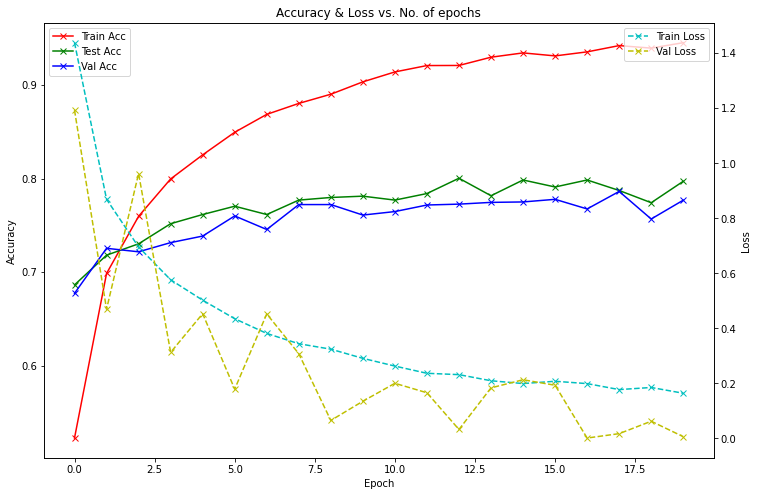

In [30]:
plt.rcParams["figure.figsize"] = (12,8)
fig, ax = plt.subplots()
plt.plot(train_acc_list, '-rx', label='Train Acc')
plt.plot(test_acc_list, '-gx', label='Test Acc')
plt.plot(val_acc_list, '-bx', label='Val Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#ax.tick_params('vals', colors='r')

# Get second axis
ax2 = ax.twinx()
plt.plot(train_loss_list, '--cx', label='Train Loss')
plt.plot(val_loss_list, '--yx', label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy & Loss vs. No. of epochs');